In [3]:
import pysam
import pandas as pd
import seaborn as sns

from cyvcf2 import VCF
from tqdm import tqdm

In [4]:
# load filtered bam/sam
recomb_out_filepath = "recomb_diagnosis.sam"
recomb_out = pysam.AlignmentFile(recomb_out_filepath, 'r')

# vcf file obj
vcf_filepath = "filtered_full.vcf.gz"
vcf = VCF(vcf_filepath)

In [9]:
bam_data = {'bam_position': []}

for record in tqdm(recomb_out):
    bam_data['bam_position'].append(record.reference_start)

396706it [00:00, 622917.77it/s]


In [10]:
vcf_data = {'vcf_position': []}

for variant in tqdm(vcf):
    vcf_data['vcf_position'].append(variant.start)

128447it [00:00, 130128.78it/s]


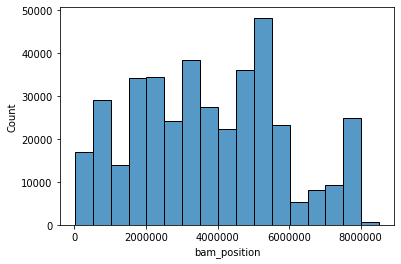

In [44]:
# plotting
sns.histplot(data=bam_data, x='bam_position', stat="count", binwidth=500000)

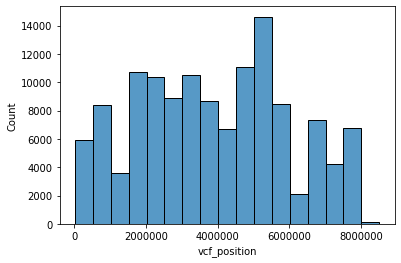

In [45]:
sns.histplot(data=vcf_data, x='vcf_position', stat="count", binwidth=500000)

{'vcf_hist': [5609, 8421, 3667, 10597, 10662, 8454, 10718, 8719, 6882, 10785, 14586, 8789, 2111, 6912, 4678, 6636, 221], 'bam_hist': [15610, 29802, 14094, 34504, 34549, 22458, 39236, 27295, 23254, 35257, 48010, 24401, 5322, 7867, 9465, 24560, 1022]}


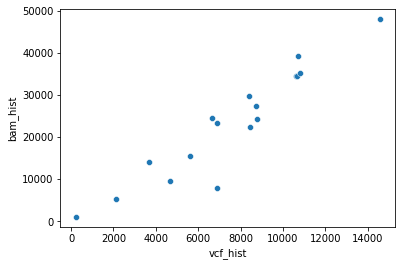

In [55]:
# usuable variants on x, phase change reads on y

def hist(binwidth):
    bin_num = int(8500000/binwidth)
    data = {'vcf_hist': [0] * bin_num, 
            'bam_hist': [0] * bin_num}
    
    for bam_pos in bam_data['bam_position']:
        data['bam_hist'][int(bam_pos/binwidth)] += 1
        
    for vcf_pos in vcf_data['vcf_position']:
        data['vcf_hist'][int(vcf_pos/binwidth)] += 1
        
    return data

print(hist(500000))

sns.scatterplot(data=hist(500000), x='vcf_hist', y='bam_hist')


In [5]:
# variants per bam sequence

def variant_per_bam(bam_filepath, vcf_filepath):
    bam = pysam.AlignmentFile(bam_filepath, 'r')
    vcf = VCF(vcf_filepath)
    
    data = {'variant_per_bam': []}
    
    for record in tqdm(bam):
        region = '{c}:{l}-{r}'.format(c=record.reference_name,
                                      l=record.reference_start,
                                      r=record.reference_start + record.query_alignment_length)
        variant_count = len([rec for rec in vcf(region)])
        data['variant_per_bam'].append(variant_count)
    
    return data

In [6]:
filtered_data = variant_per_bam('recomb_diagnosis.sam', 'filtered_full.vcf.gz')

593840it [07:48, 1268.32it/s]


In [37]:
full_data = variant_per_bam('test.sorted.bam', 'filtered_full.vcf.gz')

7737472it [1:12:52, 1769.78it/s]


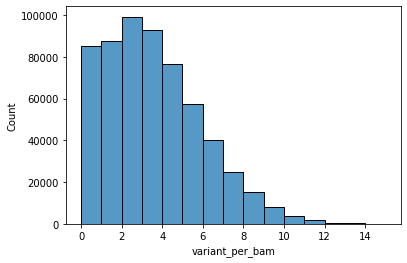

In [7]:
# plotting filtered data
sns.histplot(data=filtered_data, x='variant_per_bam', binwidth=1)

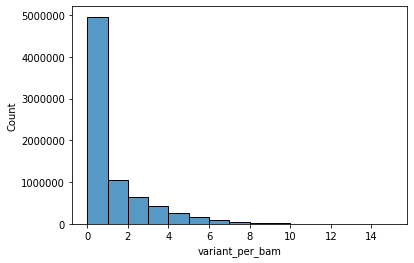

In [39]:
# plotting full data
sns.histplot(data=full_data, x='variant_per_bam', binwidth=1)

In [20]:
# variants per read pair

def variant_per_readpair(bam_filepath, vcf_filepath):
    bam = pysam.AlignmentFile(bam_filepath, 'r')
    vcf = VCF(vcf_filepath)
    
    data = {'variant_per_readpair': []}
    
    prev_record = None
    for record in tqdm(bam):   
        
        # initialize
        if prev_record == None:
            prev_record = record
        
        if prev_record.query_name != record.query_name:
            prev_record = record
        else:
            region = '{c}:{l}-{r}'.format(c=record.reference_name,
                                          l=record.reference_start,
                                          r=record.reference_start + record.query_alignment_length)
            
            prev_region = '{c}:{l}-{r}'.format(c=prev_record.reference_name,
                                          l=prev_record.reference_start,
                                          r=prev_record.reference_start + prev_record.query_alignment_length)
            
            variant_count = len([rec for rec in vcf(region)]) + len([rec for rec in vcf(prev_region)])         
            data['variant_per_readpair'].append(variant_count)
    
    return data

In [21]:
filtered_readpairs = variant_per_readpair('recomb_diagnosis.sam', 'filtered_full.vcf.gz')

593840it [07:36, 1301.74it/s]


In [25]:
full_readpairs = variant_per_readpair('test.sorted.bam', 'filtered_full.vcf.gz')

7737472it [1:09:32, 1854.29it/s]


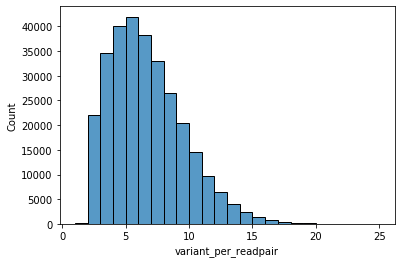

In [24]:
# plotting filtered data
sns.histplot(data=filtered_readpairs, x='variant_per_readpair', binwidth=1)

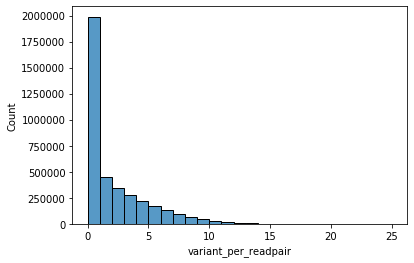

In [26]:
# plotting full data
sns.histplot(data=full_readpairs, x='variant_per_readpair', binwidth=1)